Submitted by:

Roshan Rayala Bhaskar

Sharath Kumar Krishnayya Ravindra

In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
import numpy as np

In [13]:
class ScoreNetwork0(tf.keras.Model):
    def __init__(self):
        super(ScoreNetwork0, self).__init__()
        chs = [32, 64, 128, 256, 256]
        self.convs = [
            tf.keras.Sequential([
                tf.keras.layers.Conv2D(chs[0], kernel_size=3, padding='same', activation='relu'),  # (batch, 28, 28, chs[0])
            ]),
            tf.keras.Sequential([
                tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),  # (batch, 14, 14, chs[0])
                tf.keras.layers.Conv2D(chs[1], kernel_size=3, padding='same', activation='relu'),  # (batch, 14, 14, chs[1])
            ]),
            tf.keras.Sequential([
                tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),  # (batch, 7, 7, chs[1])
                tf.keras.layers.Conv2D(chs[2], kernel_size=3, padding='same', activation='relu'),  # (batch, 7, 7, chs[2])
            ]),
            tf.keras.Sequential([
                tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),  # (batch, 4, 4, chs[2])
                tf.keras.layers.Conv2D(chs[3], kernel_size=3, padding='same', activation='relu'),  # (batch, 4, 4, chs[3])
            ]),
            tf.keras.Sequential([
                tf.keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'),  # (batch, 2, 2, chs[3])
                tf.keras.layers.Conv2D(chs[4], kernel_size=3, padding='same', activation='relu'),  # (batch, 2, 2, chs[4])
            ]),
        ]
        self.tconvs = [
            tf.keras.Sequential([
                tf.keras.layers.Conv2DTranspose(chs[3], kernel_size=3, strides=2, padding='same', activation='sigmoid'),  # (batch, 4, 4, chs[3])
            ]),
            tf.keras.Sequential([
                tf.keras.layers.Conv2DTranspose(chs[2], kernel_size=3, strides=2, padding='same', activation='sigmoid'),  # (batch, 8, 8, chs[2])
            ]),
            tf.keras.Sequential([
                tf.keras.layers.Conv2DTranspose(chs[1], kernel_size=3, strides=2, padding='same', activation='sigmoid'),  # (batch, 16, 16, chs[1])
            ]),
            tf.keras.Sequential([
                tf.keras.layers.Conv2DTranspose(chs[0], kernel_size=3, strides=2, padding='same', activation='sigmoid'),  # (batch, 32, 32, chs[0])
            ]),
            tf.keras.Sequential([
                tf.keras.layers.Conv2D(chs[0], kernel_size=3, padding='same', activation='sigmoid'),  # (batch, 32, 32, chs[0])
                tf.keras.layers.Conv2D(1, kernel_size=3, padding='same'),  # (batch, 32, 32, 1)
            ]),
        ]

    def call(self, x, t):
        # Reshape and concatenate the time dimension
        x2 = tf.reshape(x, (-1, 28, 28, 1))  # (..., 28, 28, 1)
        tt = tf.reshape(t, (-1, 1, 1, 1))  # (..., 1, 1, 1)
        tt = tf.tile(tt, [1, 28, 28, 1])  # (..., 28, 28, 1)
        x2t = tf.concat((x2, tt), axis=-1)

        signals = []
        signal = x2t
        for conv in self.convs:
            signal = conv(signal)
            signals.append(signal)

        for i, tconv in enumerate(self.tconvs):
            signal = tconv(signal)
            if i < len(self.tconvs) - 1:
                signal = tf.image.resize(signal, tf.shape(signals[-(i + 2)])[1:3])  # Resize to match the shape
                signal = tf.concat((signal, signals[-(i + 2)]), axis=-1)

        signal = tf.reshape(signal, (-1, 28 * 28))  # (..., 28 * 28)
        return signal

score_network = ScoreNetwork0()


In [11]:
def calc_loss(score_network: tf.keras.Model, x: tf.Tensor) -> tf.Tensor:
    # x: (batch_size, nch) is the training data

    # sample the time
    t = tf.random.uniform((tf.shape(x)[0], 1), minval=1e-4, maxval=1-1e-4, dtype=x.dtype)

    # calculate the terms for the posterior log distribution
    int_beta = (0.1 + 0.5 * (20 - 0.1) * t) * t  # integral of beta
    mu_t = x * tf.exp(-0.5 * int_beta)
    var_t = -tf.math.expm1(-int_beta)
    x_t = tf.random.normal(tf.shape(x), dtype=x.dtype) * tf.sqrt(var_t) + mu_t
    grad_log_p = -(x_t - mu_t) / var_t  # (batch_size, nch)

    # calculate the score function
    score = score_network(x_t, t)  # score: (batch_size, nch)

    # calculate the loss function
    loss = tf.square(score - grad_log_p)
    lmbda_t = var_t
    weighted_loss = lmbda_t * loss
    return tf.reduce_mean(weighted_loss)

In [16]:
# Prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28*28)

# Create TensorFlow dataset
batch_size = 64
dataset = Dataset.from_tensor_slices(x_train).batch(batch_size).shuffle(buffer_size=1024)

# Define optimizer
optimizer = Adam(learning_rate=3e-4)

# Training loop
epochs = 50
t0 = time.time()

for i_epoch in range(epochs):
    total_loss = 0
    for step, data in enumerate(dataset):
        data = tf.reshape(data, (data.shape[0], -1))

        with tf.GradientTape() as tape:
            loss = calc_loss(score_network, data)

        gradients = tape.gradient(loss, score_network.trainable_variables)
        optimizer.apply_gradients(zip(gradients, score_network.trainable_variables))

        total_loss += loss.numpy() * data.shape[0]

        # Print the training stats
    if i_epoch % 10 == 0:
      print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(x_train)}")


0 (58.9754524230957s): 0.06461536778608958
10 (648.9221339225769s): 0.02937185218632221
20 (1264.386801958084s): 0.02383464084515969
30 (1884.6232216358185s): 0.021455474148193994
40 (2522.6406095027924s): 0.020008708360791206


In [18]:
def generate_samples(score_network: tf.keras.Model, nsamples: int) -> tf.Tensor:
    x_t = tf.random.normal((nsamples, 28 * 28), dtype=tf.float32)  # (nsamples, nch)
    time_pts = tf.linspace(1.0, 0.0, 1000)  # (ntime_pts,)

    def beta(t):
        return 0.1 + (20 - 0.1) * t

    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t

        # Calculate the drift and diffusion terms
        fxt = -0.5 * beta(t) * x_t
        gt = tf.sqrt(beta(t))
        t_expanded = tf.expand_dims(t, axis=0)
        t_broadcast = tf.tile(t_expanded, [nsamples])
        t_reshaped = tf.reshape(t_broadcast, (-1, 1))
        score = score_network(x_t, t_reshaped)
        drift = fxt - gt * gt * score
        diffusion = gt

        # Euler-Maruyama step
        x_t = x_t + drift * dt + diffusion * tf.random.normal(x_t.shape, dtype=tf.float32) * tf.abs(dt) ** 0.5

    return x_t

In [30]:
samples = generate_samples(score_network, 21)
reshaped_samples = tf.reshape(samples, (-1, 28, 28))

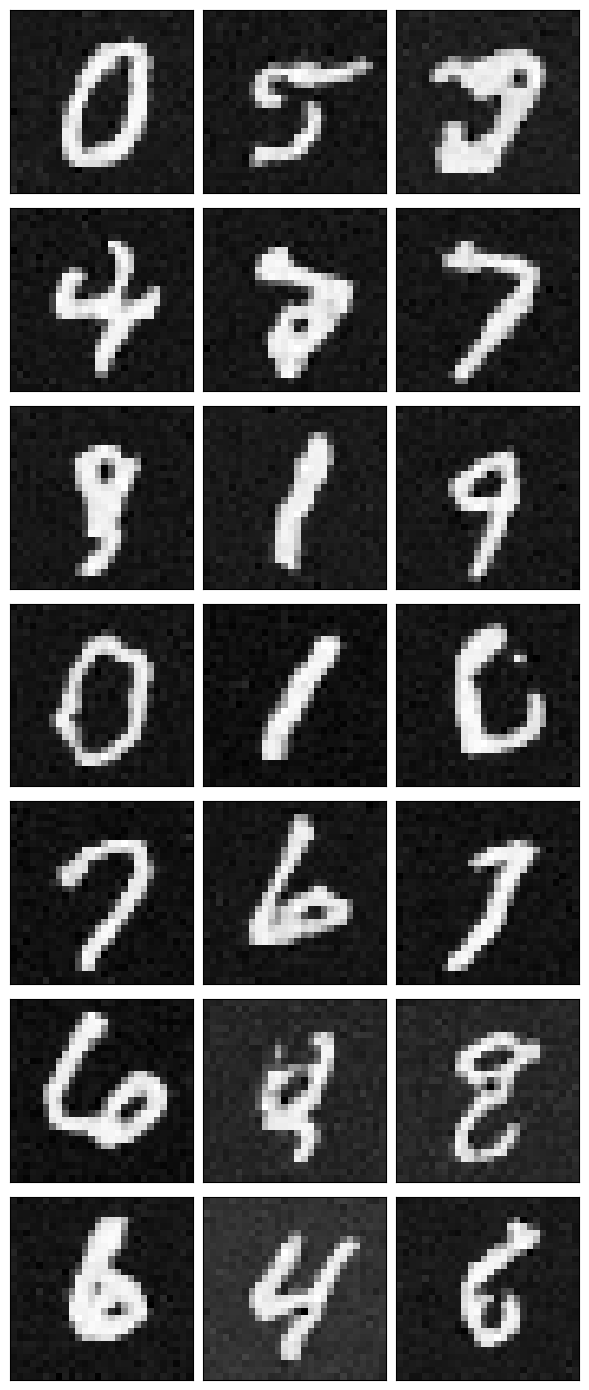

In [31]:
nrows, ncols = 7, 3
plt.figure(figsize=(2 * ncols, 2 * nrows))
for i in range(reshaped_samples.shape[0]):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(1 - reshaped_samples[i], cmap="Greys")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()